# Data exploration and data preprocessing

Here we will see:
- How many images we have
- How many contain hands
- How big is the average video

After this we set some thresholds to decide what we will actually use in the final dataset.
Since the data set is now completely mixed for the preprocessing we also what the seperate them.

In [1]:
import json, os, re, glob
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
%matplotlib inline

In [2]:
json_dir= '../../data/json_2/'
train_dir = '../../data/train/'

In [3]:
files = os.listdir(json_dir)
frame_amount = []
hand_percentage = []
left_hand= []
right_hand = []
all_labels = []
no_person_per = []
for i, file in enumerate(files):
  # If there is a file that is not a json (.DS_store wtf)
  if 'json' not in file:
    continue
    
  # Load the json file
  with open(join(json_dir,file),'rb') as f:
    json_all = json.load(f)
    json_arr = json_all['data']
  
  
  # Check the number of frames
  num_frames = len(json_arr.keys())
  frame_amount.append(num_frames)
 
  # Check how many actually have hands
  c_lhands = 0
  c_rhands = 0
  hands = 0
  no_person = 0
  for k in json_arr.keys():
    try:
      person = json_arr[k][0]
    except:
      no_person += 1
      continue
      
    try:
      lhand = sum(json_arr[k][0]['hand_left_keypoints']) > 0
      rhand = sum(json_arr[k][0]['hand_right_keypoints']) > 0
      if lhand | rhand:
        hands += 1
      
      if lhand:
        c_lhands +=1
      if rhand:
        c_rhands +=1
    except:
      continue
  
  hand_percentage.append(hands/num_frames)
  left_hand.append(c_lhands/num_frames)
  right_hand.append(c_rhands/num_frames)
  
  no_person_per.append(1 - no_person/num_frames)
  
  # Check the label
  all_labels.append(json_all['label'])

In [4]:
hist = np.histogram(frame_amount, bins = 52-10, range = (10,52))

[]

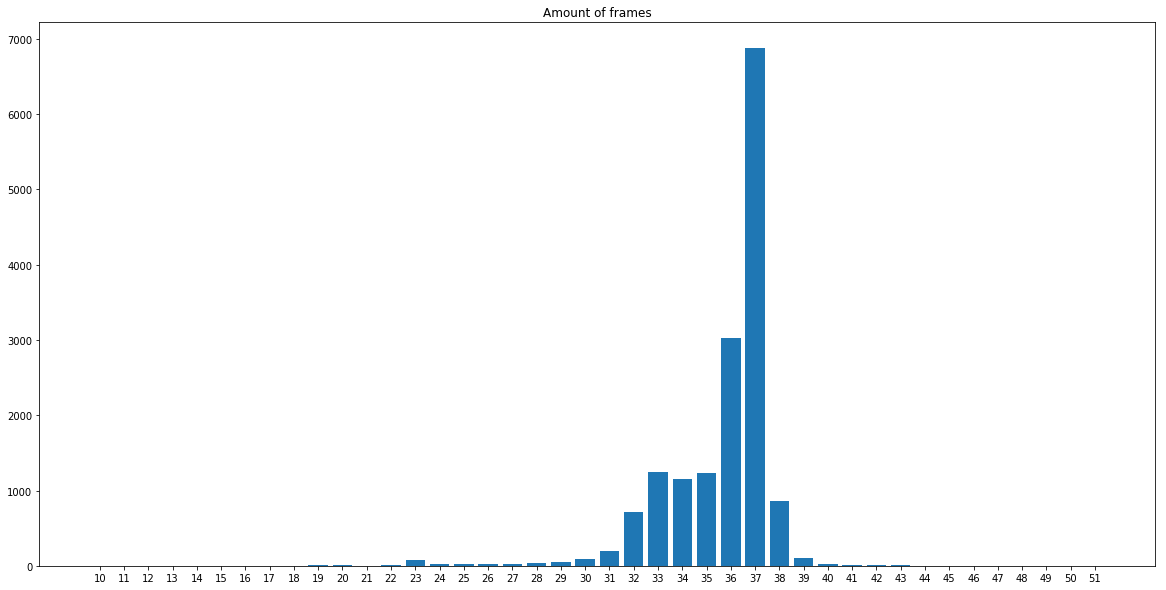

In [5]:
plt.figure(figsize = (20,10))
plt.bar(hist[1][:-1],hist[0])
plt.xticks(hist[1][:-1])
plt.title('Amount of frames')
plt.plot()

In [6]:
hand_stuff = np.histogram(hand_percentage, bins = 20, range = (0,1) )
lhand_stuff = np.histogram(left_hand, bins = 20, range = (0,1) )
rhand_stuff = np.histogram(right_hand, bins = 20, range = (0,1) )
person_stuff = np.histogram(no_person_per, bins = 20, range = (0,1) )

In [7]:
person_stuff

(array([   60,    14,    18,    18,    34,    34,    36,    45,    54,
           46,    83,    72,   111,   106,   144,   196,   224,   259,
          443, 13843]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

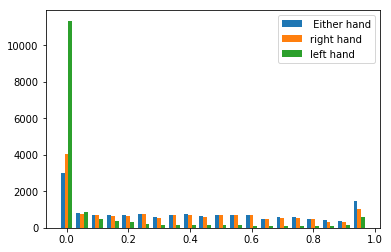

In [8]:
width = (hand_stuff[1][1]-hand_stuff[1][0])/4
plt.bar(hand_stuff[1][:-1]-width, hand_stuff[0], width = width , label =' Either hand')
plt.bar(rhand_stuff[1][:-1], rhand_stuff[0], width = width, label ='right hand')
plt.bar(lhand_stuff[1][:-1]+width, lhand_stuff[0], width = width, label = 'left hand')
plt.legend()

(array([   60,    14,    18,    18,    34,    34,    36,    45,    54,
           46,    83,    72,   111,   106,   144,   196,   224,   259,
          443, 13843]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

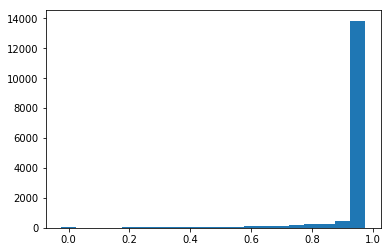

In [9]:
plt.bar(person_stuff[1][:-1], person_stuff[0], width = person_stuff[1][1]-person_stuff[1][0])
person_stuff

In [10]:
mul_5 =  5
sum(hand_stuff[0][:mul_5])/sum(hand_stuff[0])

0.3715277777777778

15840


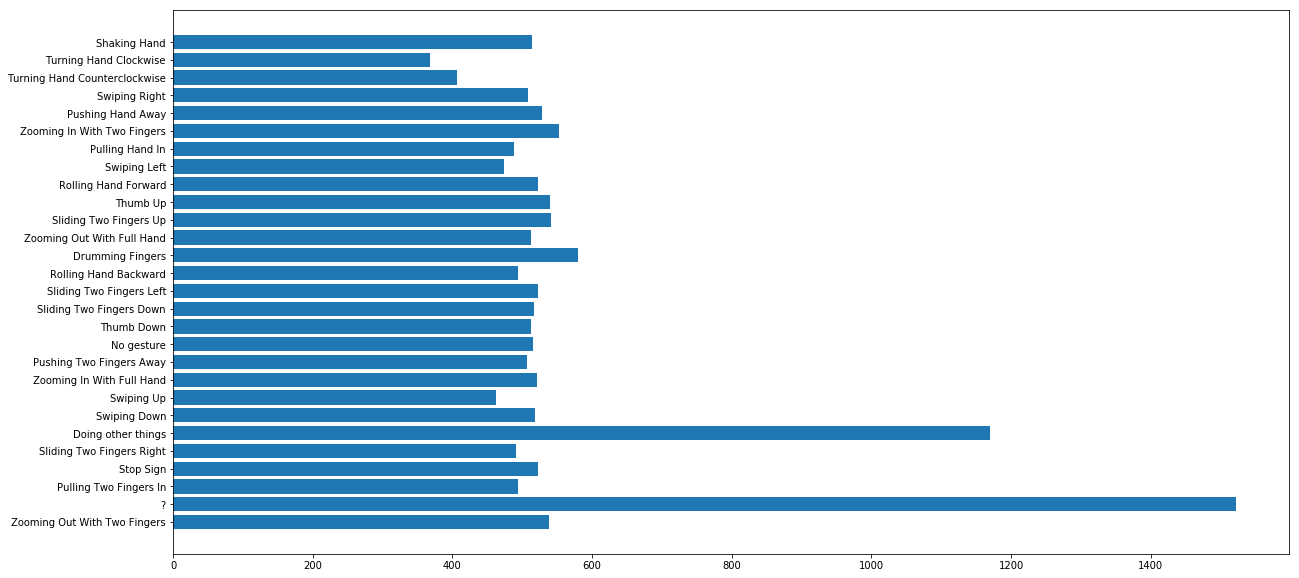

In [11]:
print(len(all_labels))
count = Counter(all_labels)
x, y = count.keys(), count.values()
plt.figure(figsize= (20,10))
plt.barh(list(range(len(x))), y)
_ = plt.yticks(list(range(len(x))),x)

----

For now I think we should try to keep most of the images. But they should at least contain hands. 

Since we can't do anything with the '?' class. This is the test class. 

Also to make it easier now to get the classifier running we will take the videos containing 37 frames

Since we will be opening all the json files anyway it makes sence to already preformat them in to a numpy array.

Since the body is represented using 18 points and the left (right) hand is represented using 21 key points. 


In [12]:
def make_numpy_array(file):
  result = np.zeros((37,120))
  for k in sorted(list(file['data'].keys())):
    k_int = int(k)
    try:
      data = file['data'][k][0]
      bla = np.r_[data['pose_keypoints'], data['hand_left_keypoints'], data['hand_right_keypoints']]
      bla = bla[[False if i %3 ==2 else True for i in range(len(bla))]]
      result[k_int-1] = bla
    except:
      None
  return result

def get_class(file):
  f_id = re.findall(r'([0-9]*).json', file)[0]
  f_label = id_label_dict[f_id]
  f_class = label_class_dict[f_label]
  
  return f_class



In [13]:
train_labels = '../labels/train.csv'
val_labels = '../labels/validation.csv'
all_labels = '../labels/labels.csv'

labels = pd.read_csv(train_labels, index_col=0, sep=';', header=None)
labels = json.loads(labels.to_json())['1']

validation_labels = pd.read_csv(val_labels, index_col=0, sep=';', header=None)
validation_labels = json.loads(validation_labels.to_json())['1']

labels.update(validation_labels)
id_label_dict = labels
df = pd.read_csv(all_labels, header = None).reset_index()
label_class_dict = dict(df[[0,'index']].values)

In [19]:
all_labels_red = []
hand_percentage = []
for i, file in enumerate(files):
  # If there is a file that is not a json (.DS_store wtf)
  if 'json' not in file:
    continue
    
  # Load the json file
  with open(join(json_dir,file),'rb') as f:
    json_all = json.load(f)
    
  if json_all['label'] == '?':
    continue
    
  json_data = json_all['data']
  # Check the number of frames
  json_frames = sorted(json_data.keys())
 
  if int(json_frames[-1]) > 37 | len(json_frames) < 30:
    continue

  # Check how many actually have hands
  hands = 0
  for k in json_frames:
    try:
      lhand = sum(json_data[k][0]['hand_left_keypoints']) > 0
      rhand = sum(json_data[k][0]['hand_right_keypoints']) > 0
      if lhand | rhand:
        hands += 1
    except:
      None

  if hands/num_frames == 0:
    continue
   
  result = make_numpy_array(json_all)
  
  
  np.save(join(train_dir,file[:-5]), result) 
  
  
  # Check the label
  hand_percentage.append(hands/num_frames)
  all_labels_red.append(json_all['label'])

12023


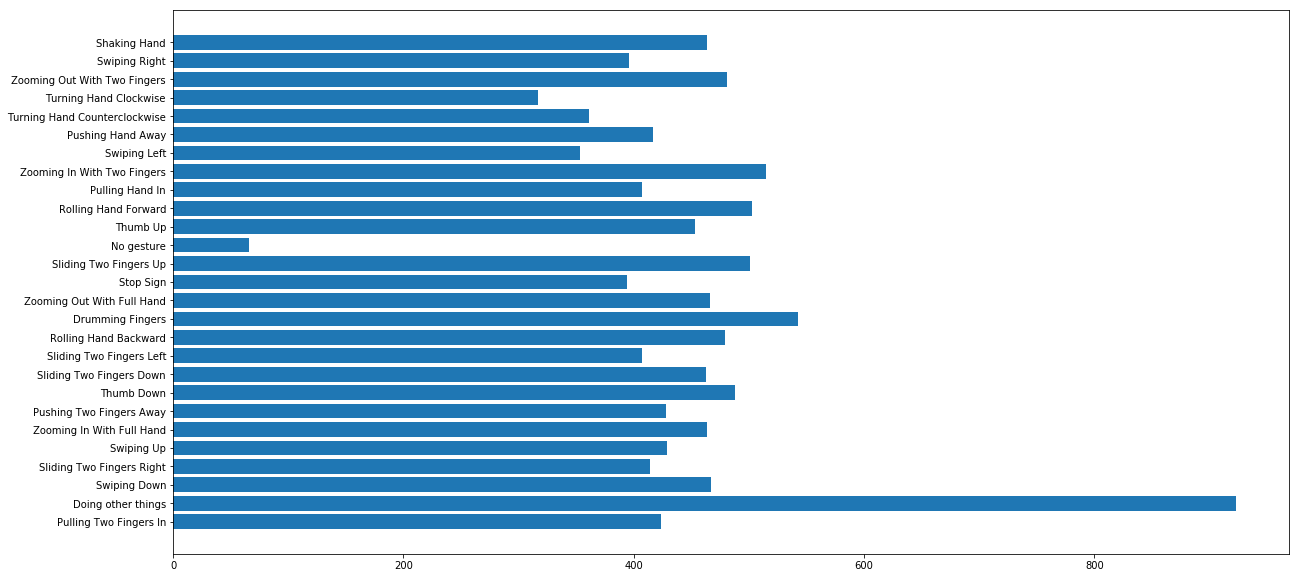

In [17]:
print(len(all_labels_red))
count = Counter(all_labels_red)
x, y = count.keys(), count.values()
plt.figure(figsize= (20,10))
plt.barh(list(range(len(x))), y)
_ = plt.yticks(list(range(len(x))),x)

<Container object of 20 artists>

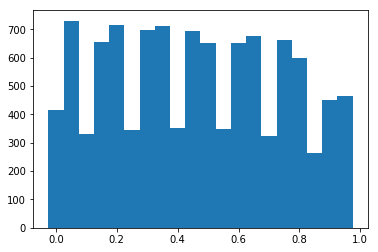

In [18]:
hand_stuff = np.histogram(hand_percentage, bins = 20, range = (0,1) )
plt.bar(hand_stuff[1][:-1], hand_stuff[0], width = hand_stuff[1][1]-hand_stuff[1][0])


In [ ]:
with open('../../data/json/60053.json','rb') as f:
  j_file = json.load(f)

len(j_file['data'].keys())

In [ ]:
j_frm = j_file['data'].keys()

In [ ]:
j_sorted = sorted(list(j_frm))

In [ ]:
int(j_sorted[-1])

In [ ]:
np.array([[[1,2],[2,3]],[[3,4],[4,5]]]).reshape(-1,2)

In [ ]:
files = glob.glob('../../data/train/*.npy')
len(files)

In [ ]:
X_data = np.r_[[np.load(files[i]) for i in range(len(files))]]

In [ ]:
X = X_data.reshape(-1,120)

In [ ]:
X_data